--------------------------------------------------------------------------------------
# **CIFAR-10 Image Classification**
---------------------------------------------------------------------------------------

**Arash Shamseddini, PhD, MSc**

-------------------
## **Context**
-------------------

**CIFAR-10** (Canadian Institute For Advanced Research) is a **collection of images with 10 different classes** representing airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. **CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects.**

Since the images in CIFAR-10 are low-resolution (32x32x3), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10.

---------------------
## **Objective**
---------------------

In this case study, I will build a number of multi-class classification algorithm to predict 10 different classes of the CIFAR-10 dataset using **Convolutional Neural Networks and Transfer Learning**.

-------------------
## **Dataset**
-------------------

The CIFAR-10 dataset consists of 60000 32x32x3, i.e., color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. You can learn more about this dataset here - https://www.cs.toronto.edu/~kriz/cifar.html

## **Loading libraries**

In [1]:
# Imports
import keras

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU

from tensorflow.keras.optimizers import Adam

## **Importing and loading the CIFAR dataset**

The CIFAR dataset is already present in the Keras library in the form of an n-dimensional NumPy array. I will download this dataset from the Keras module here.

In [2]:
# Importing the dataset
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In case the earlier cell throws an error, please uncomment the cell below. Run it once. It will show an error. Restart the run time and then run it again.

Please note: It will definitely show an error the first time you run it and restarting the runtime is compulsory. The conversion of the tensors to numpy array in this cell may take too long to execute.

In [3]:

# Creating labels as a flat vector for tf.data
y_train_flat = y_train.reshape(-1,)
y_test_flat = y_test.reshape(-1,)

# Train/Validation split
from sklearn.model_selection import train_test_split
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train_flat, test_size=0.1, random_state=42, shuffle=True
)

# Dataset shapes
print("Train:", x_train_split.shape)
print("Validation:", x_val_split.shape)
print("Test:", x_test.shape)

# Basic normalization function
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Data augmentation function
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

# Converting to tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train_split, y_train_split))
val_ds = tf.data.Dataset.from_tensor_slices((x_val_split, y_val_split))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_flat))

# Applying normalization + augmentation
train_ds = train_ds.map(normalize).map(augment).shuffle(5000).batch(64).prefetch(2)
val_ds   = val_ds.map(normalize).batch(64).prefetch(2)
test_ds  = test_ds.map(normalize).batch(64).prefetch(2)

print("TF Data pipeline created.")

Train: (45000, 32, 32, 3)
Validation: (5000, 32, 32, 3)
Test: (10000, 32, 32, 3)
TF Data pipeline created.


In [4]:
# Checking the shape of the dataset
x_train.shape

(50000, 32, 32, 3)

Here the data is stored in a **4-dimensional NumPy array**. The first dimension **50000** is denoting **the number of images in the training data**, and each image is stacked on top of the other as a 3-dimensional NumPy array. The second dimension **32** is denoting **the number of pixels along the x-axis**, **the third dimension 32 is denoting the number of pixels along the y-axis**, and **the fourth dimension 3 is the total number of channels in those images**, i.e., these are colored images consisting of RGB (Red, Green, and Blue) channels.

Below is the 3-dimensional NumPy representation of the first image in the training data. **Each pixel in the image has 3 values - the intensity of R, G, and B channels**, and the size of each image is 32x32. So, each image is represented by 32 arrays of shape 32x3.

In [ ]:
y_train[0]

array([6], dtype=uint8)

The target labels are encoded in numerical format. Here, encoding 6 denotes the category frog. **We will create a list of category names to convert the number to its original category name.**

In [ ]:
# Checking the shape of the test data
x_test.shape

(10000, 32, 32, 3)

- There are **10,000 images in the test data**.

## **Converting NumPy arrays to images and visualizing some random images**

All the images are stored as NumPy arrays, and values in the array denote the pixel intensities of the image. Let's use matplotlib's **imshow** function to visualize the image from NumPy arrays. Below I am plotting a few random images from the dataset, to see what the images look like.

In [5]:
# Declaring the number of classes
num_classes = 10

# Creating a list of category names in alphabetical order
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

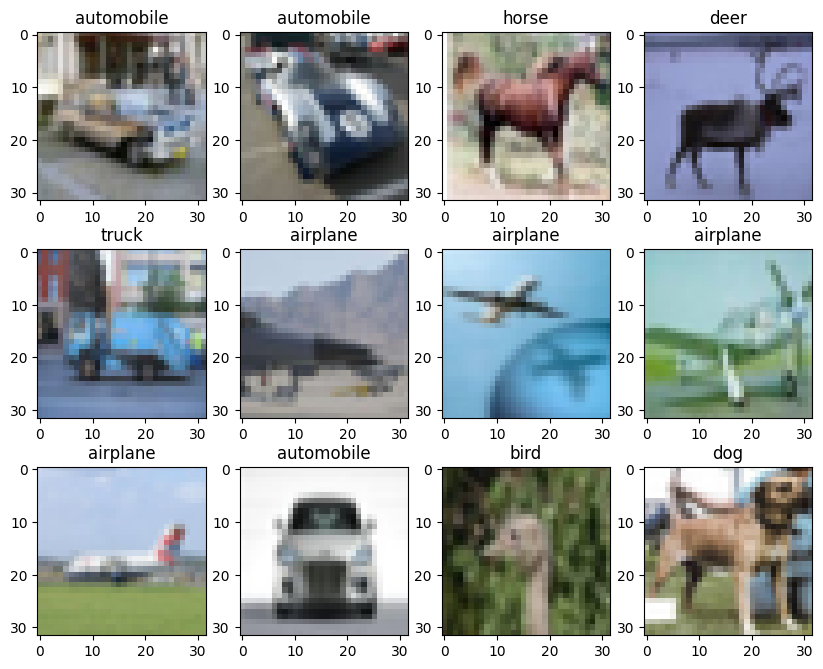

In [6]:
# Declaring the number of rows
rows = 3

# Declaring the number of columns
cols = 4

fig = plt.figure(figsize = (10, 8))

for i in range(cols):

    for j in range(rows):

        random_index = np.random.randint(0, len(y_train))

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)

        ax.imshow(x_train[random_index, :])

        ax.set_title(cifar10_classes[y_train[random_index, 0]])

# Display the plot
plt.show()

## **Data Preparation**

In neural networks, it is always suggested to **normalize the feature inputs**. Normalization has the below benefits while training a neural network model:

1. **Normalization makes the training faster and reduces the chances of getting stuck at local optima.**
2. Also, **weight decay and estimation can be done more conveniently** with normalized inputs.
3. In deep neural networks, **normalization helps to avoid exploding gradient problems.** Gradient exploding problem occurs when large error gradients accumulate and result in very large updates to neural network model weights during training. This makes a model unstable and unable to learn from the training data.

As we know, image pixel **values range from 0 - 255**, so we are simply **dividing all the pixel values by 255 to standardize all the images to have values between 0 - 1.**

In [ ]:
# Normalizing the image pixels
x_train_normalized = x_train/255

x_test_normalized = x_test/255

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
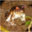

In [7]:
x_train[0]

Since this is a **10 class classification problem**, the output layer should have **10 neurons**, which will provide us with the probabilities of the input image belonging to each of those 10 classes. Therefore, we also need to create a **one-hot encoded representation for the target classes.**

In [ ]:
# Creating one-hot encoded representation of target labels

# We can do this by using this utility function - https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
y_train_encoded = tf.keras.utils.to_categorical(y_train)

y_test_encoded = tf.keras.utils.to_categorical(y_test)

## **Model Building**

Let's now create a few CNN model sequentially where we will be adding the layers one after another.

## Model 1

The first model I am going to build is a simple CNN with a few convolution and pooling layers.

First, let's **set the seed for random number generators in NumPy, Python, and TensorFlow** to be able to reproduce the same results every timethe code is run.

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

Let's build a **CNN model with Leaky Rectified Linear Unit (LeakyRelu)** as the activation function. LeakyReLU is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. The slope coefficient is determined before training, i.e., it is not learned during training.

**Note:**
- In Keras, the input must be 4-dimensional to pass them to a CNN model.
- Here, we already have a 4-dimensional input as these are colored images.
- In the case of grayscale images, we must reshape the input features to specifically mention that we have only 1 channel, i.e., gray.

In [14]:
# Initialized a sequential model
model_1 = Sequential()

# Adding the first convolutional layer with 16 filters and the kernel size of 3x3, and 'same' padding

# The input_shape denotes input dimension of CIFAR images
model_1.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", input_shape = (32, 32, 3)))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_1.add(LeakyReLU(0.1))

# Adding the second convolutional layer with 32 filters and the kernel size of 3x3
model_1.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_1.add(LeakyReLU(0.1))

# Adding max pooling to reduce the size of the output of second convolutional layer
model_1.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the 3-d output of the convolutional layer after max pooling to make it ready for creating dense connections
model_1.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
model_1.add(Dense(256))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_1.add(LeakyReLU(0.1))

# Adding the output layer with 10 neurons and 'softmax' activation function (for a multi-class classification problem)
model_1.add(Dense(10, activation = 'softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Printing the model summary
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,105,066 (8.03 MB)

 Trainable params: 2,105,066 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

As we can see from the above summary, this CNN model will train and learn **2,105,066 parameters (weights and biases).**

Let's now compile and train the model using the train data. Here, we are using the loss function - **categorical_crossentropy** as this is a multi-class classification problem. We will try to minimize this loss at every iteration using the **optimizer** of our choice. Also, we are choosing **accuracy** as the metric to measure the performance of the model.

In [19]:
# Compiling the 1st model
model_1.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
# Training 1st model with cross validation
history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=2
)

Epoch 1/10
704/704 - 50s - 71ms/step - accuracy: 0.4528 - loss: 1.5400 - val_accuracy: 0.5436 - val_loss: 1.2997
Epoch 2/10
704/704 - 46s - 65ms/step - accuracy: 0.5783 - loss: 1.1961 - val_accuracy: 0.5950 - val_loss: 1.1432
Epoch 3/10
704/704 - 50s - 70ms/step - accuracy: 0.6247 - loss: 1.0695 - val_accuracy: 0.6238 - val_loss: 1.0921
Epoch 4/10
704/704 - 51s - 73ms/step - accuracy: 0.6495 - loss: 0.9897 - val_accuracy: 0.6582 - val_loss: 0.9948
Epoch 5/10
704/704 - 45s - 64ms/step - accuracy: 0.6725 - loss: 0.9302 - val_accuracy: 0.6568 - val_loss: 0.9922
Epoch 6/10
704/704 - 51s - 72ms/step - accuracy: 0.6928 - loss: 0.8786 - val_accuracy: 0.6956 - val_loss: 0.9112
Epoch 7/10
704/704 - 44s - 63ms/step - accuracy: 0.7087 - loss: 0.8368 - val_accuracy: 0.6736 - val_loss: 0.9836
Epoch 8/10
704/704 - 45s - 64ms/step - accuracy: 0.7198 - loss: 0.8031 - val_accuracy: 0.6838 - val_loss: 0.9752
Epoch 9/10
704/704 - 81s - 115ms/step - accuracy: 0.7326 - loss: 0.7704 - val_accuracy: 0.6976 -

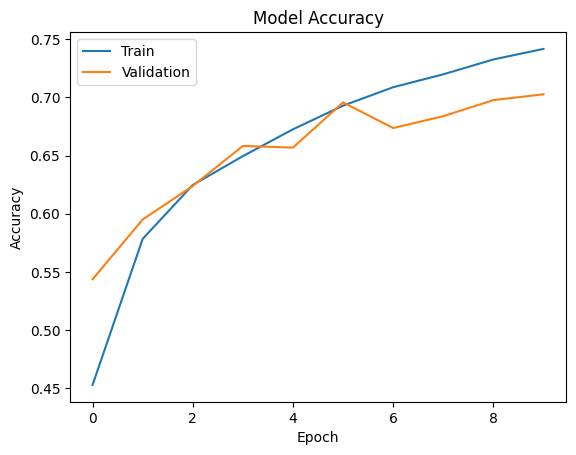

In [21]:
# Plotting accuracy vs epoch
plt.plot(history_1.history['accuracy'])

plt.plot(history_1.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc = 'upper left')

# Display the plot
plt.show()

In [25]:
# Evaluating the model on test data
test_loss, test_acc = model_1.evaluate(test_ds)
print("Test accuracy for model 1:", round(test_acc, 3))


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7032 - loss: 0.9294
Test accuracy: 0.703


**Observations:**

- We can see from the above plot that the model has done poorly on the validation data. The model is highly overfitting the training data.
- The validation accuracy has become more or less constant after 2 epochs.

## Model 2

Let's try adding a few dropout layers to the model structure to reduce overfitting and see if this improves the model or not.

First, it is necessary to clear the previous model's history from the session.

Also, let's fix the seed again after clearing the backend.

In [26]:
# Clearing the backend
from tensorflow.keras import backend

backend.clear_session()

In [27]:
# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [28]:
# Initialized a sequential model
model_2 = Sequential()

# Adding the first convolutional layer with 16 filters and the kernel size of 3x3, and 'same' padding

# The input_shape denotes the input dimension of CIFAR images
model_2.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", input_shape = (32, 32, 3)))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_2.add(LeakyReLU(0.1))

# Adding dropout to randomly switch off 20% neurons to reduce overfitting
model_2.add(Dropout(0.2))

# Adding the second convolutional layer with 32 filters and the kernel size of 3x3
model_2.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_2.add(LeakyReLU(0.1))

# Adding dropout to randomly switch off 20% neurons to reduce overfitting
model_2.add(Dropout(0.2))

# Adding max pooling to reduce the size of output of second convolutional layer
model_2.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the 3-d output of the convolutional layer after max pooling to make it ready for creating dense connections
model_2.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
model_2.add(Dense(256))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_2.add(LeakyReLU(0.1))

# Adding dropout to randomly switch off 50% neurons to reduce overfitting
model_2.add(Dropout(0.5))

# Adding the output layer with 10 neurons and 'softmax'  activation function since this is a multi-class classification problem
model_2.add(Dense(10, activation = 'softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# Printing the model summary
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,105,066 (8.03 MB)

 Trainable params: 2,105,066 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Compiling the 2nd model
model_2.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    metrics=['accuracy']
)

In [31]:
# # Training 2nd model with cross validation
history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=2
)

Epoch 1/10
704/704 - 58s - 82ms/step - accuracy: 0.4189 - loss: 1.6136 - val_accuracy: 0.5030 - val_loss: 1.4271
Epoch 2/10
704/704 - 62s - 88ms/step - accuracy: 0.5181 - loss: 1.3497 - val_accuracy: 0.5044 - val_loss: 1.5867
Epoch 3/10
704/704 - 77s - 109ms/step - accuracy: 0.5550 - loss: 1.2529 - val_accuracy: 0.5886 - val_loss: 1.2763
Epoch 4/10
704/704 - 94s - 134ms/step - accuracy: 0.5788 - loss: 1.1851 - val_accuracy: 0.5782 - val_loss: 1.3579
Epoch 5/10
704/704 - 56s - 80ms/step - accuracy: 0.5971 - loss: 1.1430 - val_accuracy: 0.6162 - val_loss: 1.1296
Epoch 6/10
704/704 - 58s - 83ms/step - accuracy: 0.6061 - loss: 1.1131 - val_accuracy: 0.6326 - val_loss: 1.1246
Epoch 7/10
704/704 - 45s - 64ms/step - accuracy: 0.6190 - loss: 1.0810 - val_accuracy: 0.6382 - val_loss: 1.1419
Epoch 8/10
704/704 - 45s - 64ms/step - accuracy: 0.6259 - loss: 1.0622 - val_accuracy: 0.6398 - val_loss: 1.1161
Epoch 9/10
704/704 - 60s - 85ms/step - accuracy: 0.6368 - loss: 1.0317 - val_accuracy: 0.6562 

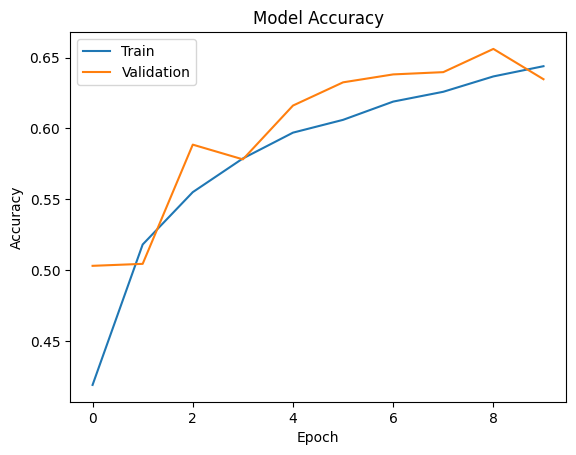

In [32]:
# Plotting accuracy vs epochs
plt.plot(history_2.history['accuracy'])

plt.plot(history_2.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc = 'upper left')

# Display the plot
plt.show()

In [33]:
# Evaluating the model on test data
test_loss, test_acc = model_2.evaluate(test_ds)
print("Test accuracy for model 2:", round(test_acc, 3))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6454 - loss: 1.1603
Test accuracy: 0.638


**Observations:**

- The second model with dropout layers seems to have reduced the overfitting in comparison to the previous model, but still, the model is not performing well on the validation data.
- The validation accuracy has decreased slightly as compared to the previous model.


## Model 3

Let's now build another model with a few more convolution layers, max-pooling layers, and dropout layers to reduce overfitting. Also, let's change the learning rate and the number of epochs and see if the model's performance improves.

In [34]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

In [35]:
# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [36]:
# Initialized a sequential model
model_3 = Sequential()

# Adding the first convolutional layer with 16 filters and the kernel size of 3x3, and 'same' padding

# The input_shape denotes input dimension of CIFAR images
model_3.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", input_shape = (32, 32, 3)))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Adding the second convolutional layer with 32 filters and the kernel size of 3x3
model_3.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Adding max pooling to reduce the size of output of the second convolutional layer
model_3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding dropout to randomly switch off 25% of the network to reduce overfitting
model_3.add(Dropout(0.25))

# Adding the third convolutional layer with 32 filters and the kernel size of 3x3
model_3.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Adding the fourth convolutional layer with 64 filters and the kernel size of 3x3
model_3.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Adding max pooling to reduce the size of output of the fourth convolutional layer
model_3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding dropout to randomly switch off 25% of the network to reduce overfitting
model_3.add(Dropout(0.25))

# Flattening the 3-d output of the convolutional layer after max pooling to make it ready for creating dense connections
model_3.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
model_3.add(Dense(256))

# Adding LeakyRelu activation function with negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Adding dropout to randomly switch off 50% of dense layer neurons to reduce overfitting
model_3.add(Dropout(0.5))

# Adding the output layer with 10 neurons and 'softmax' activation function since this is a multi-class classification problem
model_3.add(Dense(10, activation = 'softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Summary of the model
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,234 (4.14 MB)

 Trainable params: 1,084,234 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In this new architecture, although the number of convolutional layers has increased, but the total number of trainable parameters has reduced significantly (~ 50%). This is due to the addition of a few max-pooling layers in between. Let's train this model and this time for a little more epochs.

In [38]:
# Compiling the 3rd model
model_3.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [39]:
# Training the 3rd model
history_3 = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=2
)

Epoch 1/15
704/704 - 61s - 87ms/step - accuracy: 0.3723 - loss: 1.7219 - val_accuracy: 0.4674 - val_loss: 1.4772
Epoch 2/15
704/704 - 46s - 66ms/step - accuracy: 0.4828 - loss: 1.4362 - val_accuracy: 0.5404 - val_loss: 1.2899
Epoch 3/15
704/704 - 97s - 138ms/step - accuracy: 0.5272 - loss: 1.3299 - val_accuracy: 0.5578 - val_loss: 1.2229
Epoch 4/15
704/704 - 81s - 115ms/step - accuracy: 0.5508 - loss: 1.2585 - val_accuracy: 0.5954 - val_loss: 1.1338
Epoch 5/15
704/704 - 54s - 76ms/step - accuracy: 0.5737 - loss: 1.1926 - val_accuracy: 0.5876 - val_loss: 1.1440
Epoch 6/15
704/704 - 47s - 67ms/step - accuracy: 0.5966 - loss: 1.1403 - val_accuracy: 0.6282 - val_loss: 1.0374
Epoch 7/15
704/704 - 54s - 77ms/step - accuracy: 0.6129 - loss: 1.0963 - val_accuracy: 0.6270 - val_loss: 1.0569
Epoch 8/15
704/704 - 46s - 65ms/step - accuracy: 0.6282 - loss: 1.0557 - val_accuracy: 0.6268 - val_loss: 1.0547
Epoch 9/15
704/704 - 68s - 96ms/step - accuracy: 0.6381 - loss: 1.0241 - val_accuracy: 0.6482 

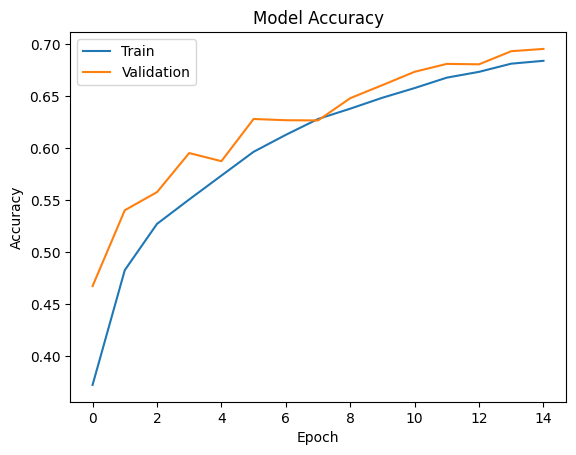

In [40]:
plt.plot(history_3.history['accuracy'])

plt.plot(history_3.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc = 'upper left')

# Display the plot
plt.show()

In [41]:
# Evaluating the model on test data
test_loss, test_acc = model_3.evaluate(test_ds)
print("Test accuracy for model 3:", round(test_acc, 3))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6991 - loss: 0.8553
Test accuracy for model 3: 0.704


**Observations:**

- The third iteration of this model seems very promising now.
- **The validation accuracy has improved substantially** and the problem of overfitting has been solved. We can say that the model is giving a generalized performance.
- The above plot shows that the validation accuracy is higher than the training accuracy. There are a few possible reasons for this:
    - The size of the validation set is not big enough.
    - We may have imbalanced data in the validation set.
    - **High regularization**. If we use regularization methods such as L2, L1, or Dropout, while the model calculates training accuracy it uses a regularized model but when it calculates accuracy on the validation set, it processes the data through an unregularized model. Regularization introduces some noise in loss value during training, because of this the training accuracy decreases more than expected, but while evaluating the model, the model doesn't use regularization, and hence there's no noise, which is why the validation accuracy doesn't decrease.
    - To overcome this, we can try reducing the regularization or increasing the size of the validation set.

I can try out some more iterations and tune some of the hyperparameters to further improve the model but hyperparameter tuning is exhaustive and can take a long time to find the right set of values for each hyperparameter.

Let's try some other techniques like transfer learning to see if I can speed up the process of training the model and can also get a more accurate model overall.

## Model 4: Transfer Learning

**Transfer learning** is a popular deep learning technique that **reuses a pre-trained model on a new problem**. **It can train deep neural networks with comparatively little data.** This is very useful in the data science field since most real-world problems typically do not have millions of labeled data points to train complex models.

Let's begin by clearing the backend and fixing the seed.

In [ ]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

I will use VGG16 as the pre-trained model. More on this model can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16).

Also, wIe will use the **Functional Model API** to build the model this time because it allows explicitly connecting the output of one layer to the input of another layer. Each connection is specified. More can be found [here](https://www.tensorflow.org/guide/keras/functional).

In [ ]:
# Importing necessary libraries
from tensorflow.keras import Model

from tensorflow.keras.applications.vgg16 import VGG16

Now, let's instantiate the VGG16 model.

- The **VGG16** model was originally trained on images of size **224 x 224**. The TensorFlow application allows the minimum image size of **32x32** which is luckily the same as the image size in the CIFAR-10 dataset.


- By specifying the argument **include_top=False argument**, I can load a network that doesn't include the classification layers at the top, i.e., we will use the VGG16 model only for feature extraction.

In [ ]:
vgg_model = VGG16(weights = 'imagenet',

                       include_top = False,

                       input_shape = (32, 32, 3), pooling = 'max')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Checking summary of the model
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

- The VGG16 model has **more than 14.7 M trainable parameters.**
- Here, **we will not train any of the layers from the VGG16 model**. We will use the pre-trained weights and biases.
- Also, we can take any layer's output from the VGG16 model as the input of our new model. Here, **we will take the output of the 3rd block of the VGG16 model as the input of our new model.**

In [ ]:
transfer_layer = vgg_model.get_layer('block3_pool')

In [ ]:
vgg_model.trainable = False

Now, we will add classification layers to our model using Functional Model API.

In [ ]:
# Add classification layers on top of it
x = Flatten()(transfer_layer.output)

x = Dense(256, activation = 'relu')(x)

x = Dense(128, activation = 'relu')(x)

x = Dropout(0.3)(x)

x = Dense(64, activation = 'relu')(x)

x = BatchNormalization()(x)

pred = Dense(10, activation = 'softmax')(x)

# Initializing the model
model_4 = Model(vgg_model.input, pred)

In [ ]:
# Compiling the model
model_4.compile(loss = 'categorical_crossentropy',

              optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.0005),

              metrics = ['accuracy'])

In [ ]:
# Fitting the model
history_4 = model_4.fit(

            x_train_normalized, y_train_encoded,

            epochs = 10,

            batch_size = 250,

            validation_split = 0.1,

            verbose = 2
)

Epoch 1/10
180/180 - 6s - loss: 1.4081 - accuracy: 0.5175 - val_loss: 0.9329 - val_accuracy: 0.6860 - 6s/epoch - 34ms/step
Epoch 2/10
180/180 - 3s - loss: 0.9671 - accuracy: 0.6716 - val_loss: 0.7816 - val_accuracy: 0.7314 - 3s/epoch - 16ms/step
Epoch 3/10
180/180 - 3s - loss: 0.8372 - accuracy: 0.7152 - val_loss: 0.7304 - val_accuracy: 0.7522 - 3s/epoch - 16ms/step
Epoch 4/10
180/180 - 3s - loss: 0.7533 - accuracy: 0.7431 - val_loss: 0.6882 - val_accuracy: 0.7666 - 3s/epoch - 16ms/step
Epoch 5/10
180/180 - 3s - loss: 0.6894 - accuracy: 0.7650 - val_loss: 0.6721 - val_accuracy: 0.7670 - 3s/epoch - 17ms/step
Epoch 6/10
180/180 - 3s - loss: 0.6455 - accuracy: 0.7818 - val_loss: 0.6443 - val_accuracy: 0.7812 - 3s/epoch - 16ms/step
Epoch 7/10
180/180 - 3s - loss: 0.5987 - accuracy: 0.7950 - val_loss: 0.6295 - val_accuracy: 0.7844 - 3s/epoch - 16ms/step
Epoch 8/10
180/180 - 3s - loss: 0.5554 - accuracy: 0.8101 - val_loss: 0.6486 - val_accuracy: 0.7798 - 3s/epoch - 16ms/step
Epoch 9/10
180/1

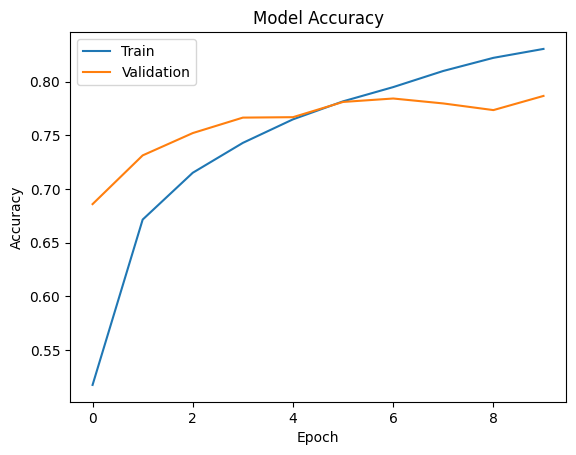

In [ ]:
plt.plot(history_4.history['accuracy'])

plt.plot(history_4.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc = 'upper left')

# Display the plot
plt.show()

**Observations:**

- The model **training accuracy is slightly higher than the validation accuracy**.
- The **validation accuracy has improved in comparison to the previous model**.
- We have been able to achieve the **best validation accuracy so far without actually training any of the convolutional layers.** There are other pre-trained models which can be tried and/or tuned to get better performance.

Here, let's use the this model to make predictions on the test data.

## **Making predictions**

In [ ]:
# Making predictions on the test data
y_pred_test = model_4.predict(x_test_normalized)

# Converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis = 1)

# Calculating the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis = 1)

313/313 [==============================] - 1s 3ms/step


              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1000
           1       0.91      0.82      0.86      1000
           2       0.65      0.77      0.71      1000
           3       0.60      0.67      0.63      1000
           4       0.78      0.72      0.75      1000
           5       0.79      0.57      0.66      1000
           6       0.78      0.86      0.82      1000
           7       0.89      0.77      0.82      1000
           8       0.87      0.89      0.88      1000
           9       0.84      0.84      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



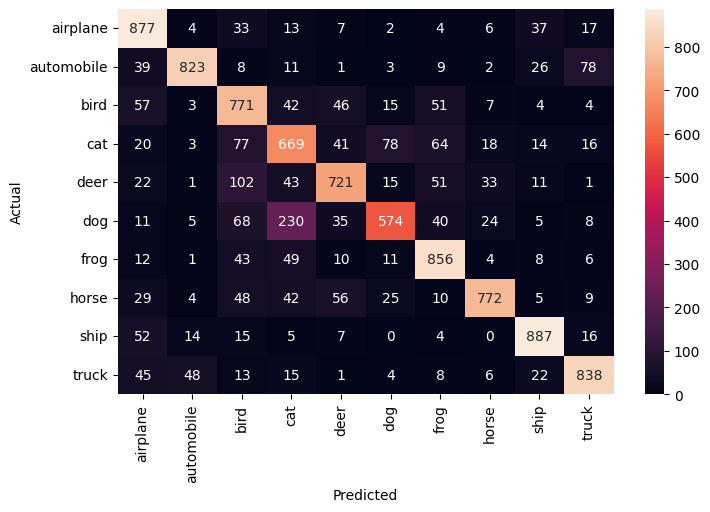

In [ ]:
# Importing required functions
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

# Printing the classification report
print(classification_report(y_test, y_pred_test_classes))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, y_pred_test_classes)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = cifar10_classes, yticklabels = cifar10_classes)

plt.ylabel('Actual')

plt.xlabel('Predicted')

# Display the plot
plt.show()

**Observations:**

- The model is giving about **79% accuracy on the test data** which is **comparable to the accuracy of the validation data.** This implies that the model is giving a generalized performance.
- The **recall has a high range** which implies that the **model is good at identifying some objects while poor at identifying some other objects**. For example, the **model can identify more than 90% of ships but can identify only ~ 54% of cats**.
- The model is majorly **confused between cats and dogs**. This implies that the **model might be focused on features related to shapes and sizes but not deep features of objects** that can help to distinguish between objects like cats and dogs.
- Consequently, **precision also has a high range with the 'cat' class having the least precision.**
- The **highest precision is for 'automobile'** which implies that the model can distinguish automobiles from other objects.

## **Visualizing the predicted images**

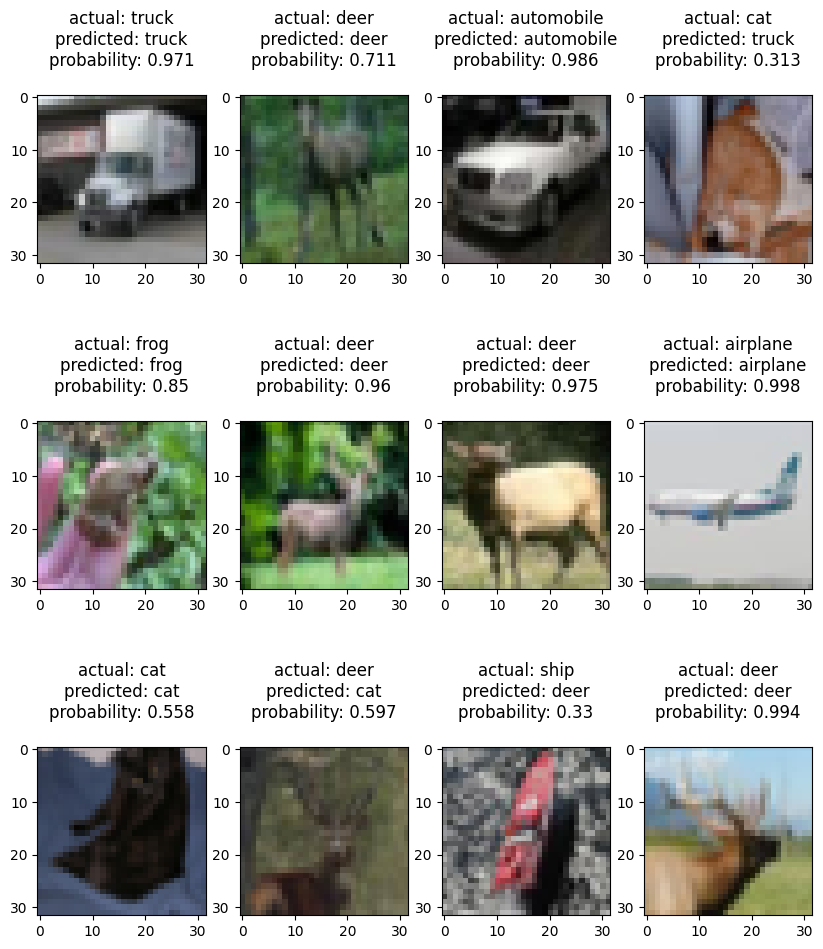

In [ ]:
rows = 3

cols = 4

fig = plt.figure(figsize = (10, 12))

for i in range(cols):

    for j in range(rows):

        random_index = np.random.randint(0, len(y_test))

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)

        ax.imshow(x_test[random_index, :])

        pred_label = cifar10_classes[y_pred_test_classes[random_index]]

        pred_proba = y_pred_test_max_probas[random_index]

        true_label = cifar10_classes[y_test[random_index, 0]]

        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba
        ))
plt.show()

## **Conclusion**

In this notebook, **we have implemented a CNN model from scratch and used transfer learning to make predictions on the CIFAR-10 dataset.** We have learned how to prepare the image data before passing it into the CNN model and how to add layers sequentially inside the model.

We have seen four different iterations of the CNN model and built an intuition about how to improve the model by tuning various hyperparameters and using different techniques. There is still plenty of scope for improvement and you can try out tuning different hyperparameters to improve the model performance.